In [125]:
#
# ============== A-to-Z Project Script (FINAL OPTIMIZED VERSION) ==============
# Project: Meta-Learning the Latent Manifold with Learnable-Interaction Neurons
# Course: Neural Networks
# Due Date: September 14th, 2025
#

import os
import argparse
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from umap import UMAP
from gtda.homology import VietorisRipsPersistence
import persim
import scipy.linalg
from torchvision.models import inception_v3, Inception_V3_Weights
from scipy.stats import entropy
import warnings
from torch.optim.lr_scheduler import CosineAnnealingLR

warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn.utils.deprecation")

# For reproducibility
torch.manual_seed(42)
np.random.seed(42)
os.environ['CUDA_LAUNCH_BLOCKING'] = "1" # For better error messages


In [126]:
# ==========================================================================================
# == 1. MODEL DEFINITIONS
# ==========================================================================================

class ChebyshevLayer(nn.Module):
    def __init__(self, in_features, out_features, order=3):
        super().__init__()
        self.in_features, self.out_features, self.order = in_features, out_features, order
        self.coeffs = nn.Parameter(torch.empty(out_features, in_features, order + 1))
        self.reset_parameters()

    def reset_parameters(self):
        with torch.no_grad():
            self.coeffs[:, :, 0].uniform_(-1e-4, 1e-4)
            self.coeffs[:, :, 2:].uniform_(-1e-4, 1e-4)
            if self.order >= 1:
                t1_coeffs = torch.empty(self.out_features, self.in_features)
                nn.init.xavier_uniform_(t1_coeffs)
                self.coeffs.data[:, :, 1] = t1_coeffs

    def forward(self, x):
        cheby_poly_list = []
        t0 = torch.ones_like(x)
        cheby_poly_list.append(t0)
        if self.order > 0:
            t1 = x
            cheby_poly_list.append(t1)
        for k in range(2, self.order + 1):
            tk = 2 * x * cheby_poly_list[k - 1] - cheby_poly_list[k - 2]
            cheby_poly_list.append(tk)
        cheby_polys = torch.stack(cheby_poly_list, dim=2)
        adaptive_weights = torch.einsum('oik,bik->boi', self.coeffs, cheby_polys)
        output = torch.einsum('bi,boi->bo', x, adaptive_weights)
        return output

In [127]:
class BaselineVAE(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=20):
        super().__init__()
        self.latent_dim = latent_dim
        self.encoder = nn.Sequential(nn.Linear(input_dim, hidden_dim), nn.ReLU())
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_log_var = nn.Linear(hidden_dim, latent_dim)
        self.decoder = nn.Sequential(nn.Linear(latent_dim, hidden_dim), nn.ReLU(), nn.Linear(hidden_dim, input_dim), nn.Sigmoid())

    def encode(self, x):
        h = self.encoder(x.view(-1, 784))
        return self.fc_mu(h), self.fc_log_var(h)

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        return self.decode(z), mu, log_var

In [128]:
class ChebyshevVAE(BaselineVAE):
    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=20, cheby_order=3):
        super().__init__(input_dim, hidden_dim, latent_dim)
        self.encoder_cheby = ChebyshevLayer(input_dim, hidden_dim, order=cheby_order)
        self.fc_mu = ChebyshevLayer(hidden_dim, latent_dim, order=cheby_order)
        self.fc_log_var = ChebyshevLayer(hidden_dim, latent_dim, order=cheby_order)
        self.decoder_cheby1 = ChebyshevLayer(latent_dim, hidden_dim, order=cheby_order)
        self.decoder_final = nn.Sequential(nn.Linear(hidden_dim, input_dim), nn.Sigmoid())

    def encode(self, x):
        x_flat = x.view(-1, 784)
        model_input = (x_flat * 2) -1
        h = torch.tanh(self.encoder_cheby(model_input))
        return self.fc_mu(h), self.fc_log_var(h)

    def decode(self, z):
        h = torch.tanh(self.decoder_cheby1(z))
        return self.decoder_final(h)

In [129]:
class ConvChebyshevVAE(nn.Module):
    def __init__(self, latent_dim=32, cheby_order=5, img_channels=1):
        super().__init__()
        self.latent_dim = latent_dim
        self.cheby_order = cheby_order

        # Deeper Encoder: 4 Conv layers with BatchNorm and LeakyReLU
        self.encoder_conv = nn.Sequential(
            # Block 1
            nn.Conv2d(img_channels, 32, kernel_size=3, stride=1, padding=1),  # 28x28
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, stride=2, padding=1),  # 14x14
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),
            # Block 2
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # 14x14
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1),  # 7x7
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            # Block 3 (shallower to avoid over-compression)
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),  # 7x7
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
        )
        # Flattened: 128 * 7 * 7 = 6272
        flat_dim = 128 * 7 * 7
        self.encoder_cheby = ChebyshevLayer(flat_dim, 512, order=cheby_order)  # Increased hidden
        self.fc_mu = nn.Linear(512, latent_dim)  # Linear for mu/logvar (stable)
        self.fc_log_var = nn.Linear(512, latent_dim)

        # Decoder: Symmetric, with residuals + Chebyshev
        self.decoder_cheby = ChebyshevLayer(latent_dim, 512, order=cheby_order)
        self.decoder_fc = nn.Linear(512, flat_dim)  # Expand before reshape
        self.decoder_conv = nn.Sequential(
            # Reshape to 128x7x7 after fc
            # Block 3 (reverse)
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1),  # 7x7 -> 7x7
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(64, 64, kernel_size=3, stride=2, padding=1, output_padding=1),  # 14x14
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            # Residual skip: Add from encoder if needed (simplified here)
            # Block 2 (reverse)
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=1, padding=1),  # 14x14
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(32, 32, kernel_size=3, stride=2, padding=1, output_padding=1),  # 28x28
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),
            # Block 1 (reverse)
            nn.ConvTranspose2d(32, img_channels, kernel_size=3, stride=1, padding=1),  # 28x28
            nn.Sigmoid()  # Output [0,1]
        )

    def encode(self, x):
        # x: (B, 1, 28, 28)
        h_conv = self.encoder_conv(x)
        h_flat = h_conv.view(h_conv.size(0), -1)  # (B, 6272)
        
        # Scale to [-1,1] more robustly
        h_norm = torch.tanh(h_flat)  # Bounded normalization
        h_cheby = self.encoder_cheby(h_norm)
        
        mu = self.fc_mu(h_cheby)
        log_var = self.fc_log_var(h_cheby)
        return mu, log_var

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h_cheby = self.decoder_cheby(z)
        h_expanded = self.decoder_fc(h_cheby).view(-1, 128, 7, 7)  # Reshape
        return self.decoder_conv(h_expanded)

    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        return self.decode(z), mu, log_var

In [130]:
# (All loss functions, data loaders, evaluation, and visualization functions remain the same)
# ...
def vae_loss_function(recon_x, x, mu, log_var):
    BCE = nn.functional.binary_cross_entropy(recon_x.view(-1, 784), x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + KLD

In [131]:
def topological_loss(X_batch, Z_batch):
    X_np = X_batch.view(X_batch.shape[0], -1).detach().cpu().numpy()
    Z_np = Z_batch.detach().cpu().numpy()
    X_point_cloud, Z_point_cloud = X_np[None, :, :], Z_np[None, :, :]
    vrp = VietorisRipsPersistence(homology_dimensions=[0, 1])
    X_diag = vrp.fit_transform(X_point_cloud)[0]
    Z_diag = vrp.fit_transform(Z_point_cloud)[0]
    total_distance = 0.0
    for dim in [0, 1]:
        X_diag_dim = X_diag[X_diag[:, 2] == dim][:, :2]
        Z_diag_dim = Z_diag[Z_diag[:, 2] == dim][:, :2]
        if X_diag_dim.shape[0] == 0 and Z_diag_dim.shape[0] == 0:
            distance_dim = 0.0
        else:
            distance_dim = persim.wasserstein(X_diag_dim, Z_diag_dim)
        total_distance += distance_dim
    return torch.tensor(total_distance, device=X_batch.device, dtype=torch.float32)

In [132]:
def disentanglement_loss(z_shared1, z_distinct1, z_shared2, z_distinct2):
    loss_shared = 1 - nn.functional.cosine_similarity(z_shared1, z_shared2, dim=-1).mean()
    pdist = nn.PairwiseDistance(p=2)
    loss_distinct = -pdist(z_distinct1, z_distinct2).mean()
    return loss_shared + loss_distinct

In [133]:
class PairedTransform:
    def __init__(self, transform): self.transform = transform
    def __call__(self, x): return self.transform(x), self.transform(x)

In [134]:
def get_dataloaders(batch_size, use_paired_transforms=False):
    base_transform = transforms.Compose([transforms.ToTensor()])
    if use_paired_transforms:
        train_transform = PairedTransform(transforms.Compose([transforms.RandomHorizontalFlip(), transforms.RandomRotation(10), transforms.ToTensor()]))
        train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=train_transform)
    else:
        train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=base_transform)
    test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=base_transform)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, test_loader

In [135]:
def calculate_fid(model, test_loader, device, latent_dim, num_samples=5000):
    print("Calculating FID score...")
    weights = Inception_V3_Weights.DEFAULT
    inception_model = inception_v3(weights=weights, transform_input=False).to(device)
    inception_model.fc = nn.Identity()
    inception_model.eval()
    
    real_features = []
    bs_test = test_loader.batch_size
    for data, _ in test_loader:
        if len(real_features) * bs_test >= num_samples: break
        data = data.to(device)
        data_resized = nn.functional.interpolate(data, size=(299, 299), mode='bilinear', align_corners=False)
        data_rgb = data_resized.repeat(1, 3, 1, 1)
        with torch.no_grad():
            features = inception_model(data_rgb)
        real_features.append(features.cpu().numpy())
    real_features = np.concatenate(real_features, axis=0)[:num_samples]

    generated_features = []
    bs_gen = 100
    with torch.no_grad():
        for i in range(0, num_samples, bs_gen):
            z = torch.randn(bs_gen, latent_dim).to(device)
            samples = model.decode(z).view(-1, 1, 28, 28)
            samples_resized = nn.functional.interpolate(samples, size=(299, 299), mode='bilinear', align_corners=False)
            samples_rgb = samples_resized.repeat(1, 3, 1, 1)
            features = inception_model(samples_rgb)
            generated_features.append(features.cpu().numpy())
    generated_features = np.concatenate(generated_features, axis=0)

    mu1, sigma1 = np.mean(real_features, axis=0), np.cov(real_features, rowvar=False)
    mu2, sigma2 = np.mean(generated_features, axis=0), np.cov(generated_features, rowvar=False)
    ssdiff = np.sum((mu1 - mu2)**2.0)
    covmean = scipy.linalg.sqrtm(sigma1.dot(sigma2))
    if np.iscomplexobj(covmean): covmean = covmean.real
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

In [136]:
def calculate_inception_score(model, device, latent_dim, num_samples=5000, splits=10):
    print("Calculating Inception Score (IS)...")
    weights = Inception_V3_Weights.DEFAULT
    inception_model = inception_v3(weights=weights, transform_input=False).to(device)
    inception_model.eval()
    
    all_preds = []
    bs = 100
    with torch.no_grad():
        for i in range(0, num_samples, bs):
            z = torch.randn(bs, latent_dim).to(device)
            samples = model.decode(z).view(-1, 1, 28, 28)
            samples_resized = nn.functional.interpolate(samples, size=(299, 299), mode='bilinear', align_corners=False)
            samples_rgb = samples_resized.repeat(1, 3, 1, 1)
            preds = inception_model(samples_rgb)
            all_preds.append(nn.functional.softmax(preds, dim=1).cpu().numpy())
    all_preds = np.concatenate(all_preds, axis=0)

    scores = []
    for i in range(splits):
        part = all_preds[i * (num_samples // splits): (i + 1) * (num_samples // splits), :]
        kl_divs = part * (np.log(part) - np.log(np.expand_dims(np.mean(part, axis=0), 0)))
        kl_divs = np.mean(np.sum(kl_divs, axis=1))
        scores.append(np.exp(kl_divs))
    return np.mean(scores), np.std(scores)

In [137]:
def save_reconstructions(model, test_loader, device, save_path):
    model.eval()
    with torch.no_grad():
        data, _ = next(iter(test_loader))
        data = data.to(device)
        recon, _, _ = model(data)
        comparison = torch.cat([data.view(-1, 1, 28, 28)[:8], recon.view(-1, 1, 28, 28)[:8]])
        from torchvision.utils import save_image
        save_image(comparison.cpu(), save_path, nrow=8)

In [138]:
def save_generated_samples(model, device, save_path, num_samples=64):
    model.eval()
    with torch.no_grad():
        z = torch.randn(num_samples, model.latent_dim).to(device)
        samples = model.decode(z).cpu()
        from torchvision.utils import save_image
        save_image(samples.view(num_samples, 1, 28, 28), save_path)

In [139]:
def save_latent_space(model, test_loader, device, save_path):
    model.eval()
    all_z, all_labels = [], []
    with torch.no_grad():
        for data, labels in test_loader:
            data = data.to(device)
            mu, _ = model.encode(data)
            all_z.append(mu.cpu().numpy())
            all_labels.append(labels.numpy())
    all_z = np.concatenate(all_z, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)
    reducer = UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
    embedding = reducer.fit_transform(all_z)
    plt.figure(figsize=(12, 10))
    plt.scatter(embedding[:, 0], embedding[:, 1], c=all_labels, cmap='Spectral', s=5)
    plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
    plt.title('UMAP Projection of the Latent Space')
    plt.savefig(save_path)
    plt.close()



In [140]:
# ==========================================================================================
# == MAIN TRAINING & EVALUATION SCRIPT
# ==========================================================================================
def main(args):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    results_dir = os.path.join("opti_results_new", args.run_name)
    os.makedirs(results_dir, exist_ok=True)

    use_paired = args.model_type in ['B', 'D', 'E'] # Include new model type
    train_loader, test_loader = get_dataloaders(args.batch_size, use_paired_transforms=use_paired)

    if args.model_type in ['A', 'B']:
        model = BaselineVAE(latent_dim=args.latent_dim).to(device)
    elif args.model_type in ['C', 'D']:
         model = ChebyshevVAE(latent_dim=args.latent_dim, cheby_order=args.cheby_order).to(device)
    elif args.model_type == 'E':
        model = ConvChebyshevVAE(latent_dim=args.latent_dim, cheby_order=args.cheby_order).to(device)
    print(f"Initialized Model {args.model_type}")
    
    optimizer = optim.Adam(model.parameters(), lr=args.lr, weight_decay=1e-5)
    
    train_losses, test_losses = [], []
    
    # ... (Training loop is modified to handle the new ConvChebyshevVAE data flow)
    for epoch in range(1, args.epochs + 1):
        model.train()
        total_train_loss = 0
        for batch_idx, data in enumerate(train_loader):
            optimizer.zero_grad()
            
            current_gamma = args.gamma if epoch > args.warmup_epochs else 0.0
            current_delta = args.delta if epoch > args.warmup_epochs else 0.0

            if use_paired:
                (data1, data2), _ = data
                data1, data2 = data1.to(device), data2.to(device)
                recon, mu, log_var = model(data1)
                loss_v = vae_loss_function(recon, data1, mu, log_var)
                
                loss_t = torch.tensor(0.0, device=device)
                if current_gamma > 0 and batch_idx % 20 == 0:
                    z = model.reparameterize(mu, log_var)
                    loss_t = topological_loss(data1, z)
                
                loss_d = torch.tensor(0.0, device=device)
                if current_delta > 0:
                    mu1, _ = model.encode(data1)
                    mu2, _ = model.encode(data2)
                    z_shared1, z_distinct1 = torch.chunk(mu1, 2, dim=1)
                    z_shared2, z_distinct2 = torch.chunk(mu2, 2, dim=1)
                    loss_d = disentanglement_loss(z_shared1, z_distinct1, z_shared2, z_distinct2)
                
                loss = loss_v + current_gamma * loss_t + current_delta * loss_d
            else:
                data, _ = data
                data = data.to(device)
                recon, mu, log_var = model(data)
                loss = vae_loss_function(recon, data, mu, log_var)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=args.grad_clip)
            optimizer.step()
            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader.dataset)
        train_losses.append(avg_train_loss)

        model.eval()
        total_test_loss = 0
        with torch.no_grad():
            for data, _ in test_loader:
                data = data.to(device)
                recon, mu, log_var = model(data)
                total_test_loss += vae_loss_function(recon, data, mu, log_var).item()
        avg_test_loss = total_test_loss / len(test_loader.dataset)
        test_losses.append(avg_test_loss)
        print(f'====> Epoch: {epoch} Average train loss: {avg_train_loss:.4f} | Average test loss: {avg_test_loss:.4f}')
    
    # ... (Rest of the main function for saving and evaluation)
    print("Training finished.")
    torch.save(model.state_dict(), os.path.join(results_dir, "model.pth"))
    
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.title('Model Loss')
    plt.legend()
    plt.savefig(os.path.join(results_dir, 'loss_curve.png'))
    plt.close()

    save_reconstructions(model, test_loader, device, os.path.join(results_dir, 'reconstructions.png'))
    save_generated_samples(model, device, os.path.join(results_dir, 'generated_samples.png'))
    save_latent_space(model, test_loader, device, os.path.join(results_dir, 'latent_space.png'))

    print(f"Results saved to {results_dir}")

    fid_score = calculate_fid(model, test_loader, device, args.latent_dim)
    is_mean, is_std = calculate_inception_score(model, device, args.latent_dim)
    print(f"====> Final FID Score: {fid_score:.4f}")
    print(f"====> Final Inception Score: {is_mean:.4f} ± {is_std:.4f}")
    with open(os.path.join(results_dir, "final_metrics.txt"), "w") as f:
        f.write(f"Final Test Loss: {avg_test_loss}\n")
        f.write(f"Final FID Score: {fid_score}\n")
        f.write(f"Final Inception Score: {is_mean} ± {is_std}\n")

In [ ]:
if __name__ == '__main__':
    class Args:
        # --- OPTIMIZED MODEL CONFIGURATION ---
        model_type = 'E'
        batch_size = 64
        epochs = 20
        lr = 1e-4 # CNNs can handle a slightly higher learning rate
        latent_dim = 20
        cheby_order = 3
        gamma = 0.05
        delta = 0.5
        grad_clip = 1.0 # CNNs are generally more stable
        warmup_epochs = 5
        run_name = 'ModelE_Conv_Optimized'

    args = Args()
    main(args)


Using device: cuda
Initialized Model E
====> Epoch: 1 Average train loss: 300.1644 | Average test loss: 275.9801
====> Epoch: 2 Average train loss: 269.6256 | Average test loss: 262.0397
====> Epoch: 3 Average train loss: 262.0494 | Average test loss: 257.3421
====> Epoch: 4 Average train loss: 258.3126 | Average test loss: 256.0918
====> Epoch: 5 Average train loss: 255.9454 | Average test loss: 252.7326
====> Epoch: 6 Average train loss: 254.4846 | Average test loss: 252.9859
====> Epoch: 7 Average train loss: 253.2915 | Average test loss: 251.2869
====> Epoch: 8 Average train loss: 252.3920 | Average test loss: 249.8153
====> Epoch: 9 Average train loss: 251.6622 | Average test loss: 249.6859
====> Epoch: 10 Average train loss: 251.0634 | Average test loss: 249.9714
====> Epoch: 11 Average train loss: 250.6017 | Average test loss: 249.1025
====> Epoch: 12 Average train loss: 250.1328 | Average test loss: 248.4058
====> Epoch: 13 Average train loss: 249.6968 | Average test loss: 248.

C:\Users\T2510570\anaconda3\envs\nn_env\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Results saved to opti_results_new\ModelE_Conv_Optimized
Calculating FID score...
Calculating Inception Score (IS)...
====> Final FID Score: 103.8363
====> Final Inception Score: 2.7607 ± 0.0712


In [ ]:
if __name__ == '__main__':
    class Args:
        # --- OPTIMIZED MODEL CONFIGURATION ---
        model_type = 'A' 
        batch_size = 64
        epochs = 20
        lr = 1e-4 # CNNs can handle a slightly higher learning rate
        latent_dim = 20
        cheby_order = 3
        gamma = 0.05
        delta = 0.5
        grad_clip = 1.0 # CNNs are generally more stable
        warmup_epochs = 5
        run_name = 'ModelA_Conv_Optimized'

    args = Args()
    main(args)

Using device: cuda
Initialized Model A
====> Epoch: 1 Average train loss: 326.6744 | Average test loss: 284.3204
====> Epoch: 2 Average train loss: 276.0221 | Average test loss: 273.1463
====> Epoch: 3 Average train loss: 268.0375 | Average test loss: 266.7090
====> Epoch: 4 Average train loss: 263.1204 | Average test loss: 263.1544
====> Epoch: 5 Average train loss: 259.7410 | Average test loss: 259.9673
====> Epoch: 6 Average train loss: 257.2274 | Average test loss: 257.9709
====> Epoch: 7 Average train loss: 255.1526 | Average test loss: 255.7517
====> Epoch: 8 Average train loss: 253.5594 | Average test loss: 254.3452
====> Epoch: 9 Average train loss: 252.1487 | Average test loss: 253.2195
====> Epoch: 10 Average train loss: 251.0122 | Average test loss: 252.2658
====> Epoch: 11 Average train loss: 250.0808 | Average test loss: 251.4470
====> Epoch: 12 Average train loss: 249.3023 | Average test loss: 250.5930
====> Epoch: 13 Average train loss: 248.6547 | Average test loss: 250.

C:\Users\T2510570\anaconda3\envs\nn_env\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Results saved to opti_results_new\ModelA_Conv_Optimized
Calculating FID score...
Calculating Inception Score (IS)...
====> Final FID Score: 105.7585
====> Final Inception Score: 2.2623 ± 0.0406


In [ ]:

if __name__ == '__main__':
    class Args:
        # --- OPTIMIZED MODEL CONFIGURATION ---
        model_type = 'D' 
        batch_size = 64
        epochs = 20
        lr = 1e-4 # CNNs can handle a slightly higher learning rate
        latent_dim = 20
        cheby_order = 3
        gamma = 0.05
        delta = 0.5
        grad_clip = 1.0 # CNNs are generally more stable
        warmup_epochs = 5
        run_name = 'ModelD_Conv_Optimized'

    args = Args()
    main(args)
  

Using device: cuda
Initialized Model D
====> Epoch: 1 Average train loss: 324.7750 | Average test loss: 288.1461
====> Epoch: 2 Average train loss: 285.5596 | Average test loss: 275.0543
====> Epoch: 3 Average train loss: 277.9423 | Average test loss: 269.9657
====> Epoch: 4 Average train loss: 273.8631 | Average test loss: 267.2721
====> Epoch: 5 Average train loss: 271.2903 | Average test loss: 265.6862
====> Epoch: 6 Average train loss: 269.5182 | Average test loss: 264.1784
====> Epoch: 7 Average train loss: 267.7209 | Average test loss: 263.1005
====> Epoch: 8 Average train loss: 265.8637 | Average test loss: 262.3209
====> Epoch: 9 Average train loss: 264.6811 | Average test loss: 261.8948
====> Epoch: 10 Average train loss: 263.6700 | Average test loss: 260.5318
====> Epoch: 11 Average train loss: 262.7404 | Average test loss: 259.6078
====> Epoch: 12 Average train loss: 261.8946 | Average test loss: 259.5853
====> Epoch: 13 Average train loss: 261.2152 | Average test loss: 258.

C:\Users\T2510570\anaconda3\envs\nn_env\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Results saved to opti_results_new\ModelD_Conv_Optimized
Calculating FID score...
Calculating Inception Score (IS)...
====> Final FID Score: 130.8841
====> Final Inception Score: 2.2360 ± 0.0242


In [ ]:

if __name__ == '__main__':
    class Args:
        # --- OPTIMIZED MODEL CONFIGURATION ---
        model_type = 'C' 
        batch_size = 64
        epochs = 20
        lr = 1e-4 # CNNs can handle a slightly higher learning rate
        latent_dim = 20
        cheby_order = 3
        gamma = 0.05
        delta = 0.5
        grad_clip = 1.0 # CNNs are generally more stable
        warmup_epochs = 5
        run_name = 'ModelC_Conv_Optimized'

    args = Args()
    main(args)


Using device: cuda
Initialized Model C
====> Epoch: 1 Average train loss: 313.9279 | Average test loss: 283.4404
====> Epoch: 2 Average train loss: 273.9909 | Average test loss: 269.6965
====> Epoch: 3 Average train loss: 265.2763 | Average test loss: 265.4652
====> Epoch: 4 Average train loss: 261.4123 | Average test loss: 262.2164
====> Epoch: 5 Average train loss: 258.8189 | Average test loss: 259.1550
====> Epoch: 6 Average train loss: 256.8448 | Average test loss: 257.9832
====> Epoch: 7 Average train loss: 255.2927 | Average test loss: 256.3813
====> Epoch: 8 Average train loss: 254.0778 | Average test loss: 255.5074
====> Epoch: 9 Average train loss: 253.0404 | Average test loss: 254.7349
====> Epoch: 10 Average train loss: 252.2185 | Average test loss: 254.3403
====> Epoch: 11 Average train loss: 251.4367 | Average test loss: 253.3203
====> Epoch: 12 Average train loss: 250.7938 | Average test loss: 252.2437
====> Epoch: 13 Average train loss: 250.1866 | Average test loss: 251.

C:\Users\T2510570\anaconda3\envs\nn_env\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Results saved to opti_results_new\ModelC_Conv_Optimized
Calculating FID score...
Calculating Inception Score (IS)...
====> Final FID Score: 111.1928
====> Final Inception Score: 2.3314 ± 0.0602


In [ ]:

if __name__ == '__main__':
    class Args:
        # --- OPTIMIZED MODEL CONFIGURATION ---
        model_type = 'B' 
        batch_size = 64
        epochs = 20
        lr = 1e-4 # CNNs can handle a slightly higher learning rate
        latent_dim = 20
        cheby_order = 3
        gamma = 0.05
        delta = 0.5
        grad_clip = 1.0 # CNNs are generally more stable
        warmup_epochs = 5
        run_name = 'ModelB_Conv_Optimized'

    args = Args()
    main(args)
    

Using device: cuda
Initialized Model B
====> Epoch: 1 Average train loss: 337.0803 | Average test loss: 291.2445
====> Epoch: 2 Average train loss: 287.8584 | Average test loss: 279.1393
====> Epoch: 3 Average train loss: 279.0515 | Average test loss: 273.4398
====> Epoch: 4 Average train loss: 273.6222 | Average test loss: 269.1976
====> Epoch: 5 Average train loss: 269.8224 | Average test loss: 266.1652
====> Epoch: 6 Average train loss: 267.0818 | Average test loss: 263.9703
====> Epoch: 7 Average train loss: 265.0478 | Average test loss: 262.1834
====> Epoch: 8 Average train loss: 263.3098 | Average test loss: 260.7197
====> Epoch: 9 Average train loss: 261.9088 | Average test loss: 259.6347
====> Epoch: 10 Average train loss: 260.8367 | Average test loss: 258.6430
====> Epoch: 11 Average train loss: 259.8694 | Average test loss: 257.6914
====> Epoch: 12 Average train loss: 259.1217 | Average test loss: 257.0276
====> Epoch: 13 Average train loss: 258.3965 | Average test loss: 256.

C:\Users\T2510570\anaconda3\envs\nn_env\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Results saved to opti_results_new\ModelB_Conv_Optimized
Calculating FID score...
Calculating Inception Score (IS)...
====> Final FID Score: 122.2052
====> Final Inception Score: 2.2543 ± 0.0347


Tabular Summary of Final Metrics:
   test_loss       fid  is_mean  is_std                         model
0   247.3731  105.7585   2.2623  0.0406        Model A (Baseline VAE)
1   253.9753  122.2052   2.2543  0.0347   Model B (Baseline + Paired)
2   249.4195  111.1928   2.3314  0.0602       Model C (Chebyshev VAE)
3   255.5776  130.8841   2.2360  0.0242  Model D (Chebyshev + Paired)
4   246.4620  103.8363   2.7607  0.0712  Model E (Conv Chebyshev VAE)

Table saved to 'metrics_summary.csv'


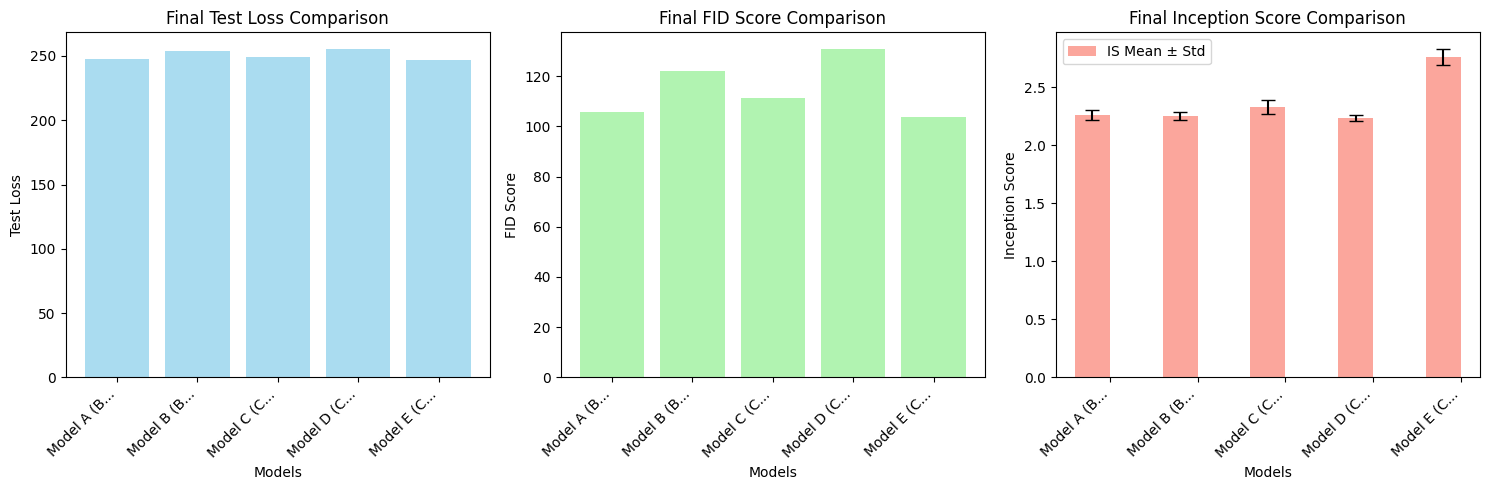

In [158]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pathlib import Path

# Define the results directory and model names
results_dir = Path("opti_results_new")
model_names = ['ModelA_Conv_Optimized', 'ModelB_Conv_Optimized', 'ModelC_Conv_Optimized', 
               'ModelD_Conv_Optimized', 'ModelE_Conv_Optimized']
model_labels = ['Model A (Baseline VAE)', 'Model B (Baseline + Paired)', 
                'Model C (Chebyshev VAE)', 'Model D (Chebyshev + Paired)', 
                'Model E (Conv Chebyshev VAE)']

# Function to extract metrics from final_metrics.txt
def extract_metrics(run_dir):
    metrics_file = run_dir / "final_metrics.txt"
    if not metrics_file.exists():
        print(f"Warning: {metrics_file} not found. Skipping {run_dir.name}")
        return None
    
    metrics = {}
    with open(metrics_file, 'r') as f:
        for line in f:
            line = line.strip()
            if line.startswith("Final Test Loss:"):
                metrics['test_loss'] = float(line.split(':')[1].strip())
            elif line.startswith("Final FID Score:"):
                metrics['fid'] = float(line.split(':')[1].strip())
            elif line.startswith("Final Inception Score:"):
                is_str = line.split(':')[1].strip().split(' ± ')
                metrics['is_mean'] = float(is_str[0])
                metrics['is_std'] = float(is_str[1])
    return metrics

# Collect metrics for all models
all_metrics = []
for model_name in model_names:
    run_dir = results_dir / model_name
    metrics = extract_metrics(run_dir)
    if metrics:
        metrics['model'] = model_labels[model_names.index(model_name)]
        all_metrics.append(metrics)

# Create DataFrame for tabular summary
df = pd.DataFrame(all_metrics)
print("Tabular Summary of Final Metrics:")
print(df.round(4))

# Save table to CSV for easy viewing/export
df.to_csv("metrics_summary.csv", index=False)
print("\nTable saved to 'metrics_summary.csv'")

# Plot comparisons for each metric
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Test Loss
axes[0].bar(range(len(df)), df['test_loss'], color='skyblue', alpha=0.7)
axes[0].set_title('Final Test Loss Comparison')
axes[0].set_xlabel('Models')
axes[0].set_ylabel('Test Loss')
axes[0].set_xticks(range(len(df)))
axes[0].set_xticklabels([m[:10] + '...' if len(m) > 10 else m for m in df['model']], rotation=45, ha='right')

# FID Score
axes[1].bar(range(len(df)), df['fid'], color='lightgreen', alpha=0.7)
axes[1].set_title('Final FID Score Comparison')
axes[1].set_xlabel('Models')
axes[1].set_ylabel('FID Score')
axes[1].set_xticks(range(len(df)))
axes[1].set_xticklabels([m[:10] + '...' if len(m) > 10 else m for m in df['model']], rotation=45, ha='right')

# Inception Score (mean)
x_pos = np.arange(len(df))
axes[2].bar(x_pos - 0.2, df['is_mean'], yerr=df['is_std'], width=0.4, 
            label='IS Mean ± Std', color='salmon', alpha=0.7, capsize=5)
axes[2].set_title('Final Inception Score Comparison')
axes[2].set_xlabel('Models')
axes[2].set_ylabel('Inception Score')
axes[2].set_xticks(x_pos)
axes[2].set_xticklabels([m[:10] + '...' if len(m) > 10 else m for m in df['model']], rotation=45, ha='right')
axes[2].legend()

plt.tight_layout()
plt.savefig('metrics_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Optional: Side-by-side loss curve comparison (if you save losses numerically)
# To do this, you'd need to modify the training script to save train_losses and test_losses as .npy files.
# For now, you can manually compare the saved PNGs or add this to the script:
# np.save(os.path.join(results_dir, 'train_losses.npy'), train_losses)
# np.save(os.path.join(results_dir, 'test_losses.npy'), test_losses)
# Then load and plot here if available.